In [12]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from missile_gym import MissileGym

In [162]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import figure, subplot2grid
from functional import seq
from ipywidgets import interact, interactive, fixed
import ipywidgets
from math import *
# %config InlineBackend.figure_format = 'svg'

In [163]:
gym = MissileGym.make_simple_scenario((-1500, 500), (-200, 0), missile_vel_abs=1.0)
done = False
reward = 0
obs = gym.reset()
state = gym.get_state()
history = []
alphas_targeting = []
while not done:
    rews = []
    for a in [-1,0,1]:
        obs, reward, done, info = gym.step(a)
        rews.append((a, reward))
        gym.set_state(state)
        
    if gym.missile.v > gym.target.v:
        action_parallel_guidance = gym.missile.get_action_parallel_guidance(gym.target)
    else:
        action_parallel_guidance = gym.missile.get_action_chaise_guidance(gym.target)
    if -0.5 <= action_parallel_guidance <= 0.5:
        action_parallel_guidance = 0
    elif action_parallel_guidance < -0.5:
        action_parallel_guidance = -1
    else:
        action_parallel_guidance = 1
    if np.random.random() < 0.5:
        action_parallel_guidance = np.random.choice([-1,0,1])
    obs, reward, done, info = gym.step(action_parallel_guidance)
    rews.append((action_parallel_guidance, reward))
    state = gym.get_state()
    history.append((state, obs, reward, done, info, rews))
    alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alphamax else copysign(gym.missile.alphamax, gym.missile.alpha_targeting))
    
#     if gym.missile.alpha < 0:
#         print(gym.missile.alpha, gym.missile._get_dydt(gym.missile.t, gym.missile.state[:-1])[3])
print(info['done_reason'])

False [-1500   500]
[25.         0.         0.         2.8198421  0.         0.       ]
мы попали


In [164]:
%matplotlib inline

In [165]:
def get_an_atau(vel0, vel1, tau):
    g = 9.81
    vel0 = np.array(vel0)
    vel1 = np.array(vel1)
    a = (vel1-vel0)/tau - np.array([0, -g])
    a_tau = np.dot(a, vel0/np.linalg.norm(vel0)) *  vel0/np.linalg.norm(vel0)
    a_n = a - a_tau
    return copysign(np.linalg.norm(a_n)/g, np.cross(vel0, a_n)), copysign(np.linalg.norm(a_tau)/g, np.dot(a_tau, vel0))
    

In [241]:
mis_xs = []
mis_ys = []
trg_xs = []
trg_ys = []
ts = []
mis_vs = []
trg_vs = []
rewards = []
rewards_1 = []
rewards0 = []
rewards1 = []
alphas = []
trg_vels = []
mis_vels = []
Qs = []
for state, obs, reward, done, info, rews in tqdm(history):
    gym.set_state(state)
    mis_smry = gym.missile.get_summary()
    trg_smry = gym.target.get_summary()
    mis_xs.append(mis_smry['x'])
    mis_ys.append(mis_smry['y'])
    trg_xs.append(trg_smry['x'])
    trg_ys.append(trg_smry['y'])
    ts.append(mis_smry['t'])
    mis_vs.append(mis_smry['v'])
    trg_vs.append(trg_smry['v'])
    rewards.append(reward)
    av = (rews[0][1] + rews[1][1]+ rews[2][1])/3
    rewards_1.append(rews[0][1]-av)
    rewards0.append(rews[1][1]-av)
    rewards1.append(rews[2][1]-av)
    alphas.append(mis_smry['alpha'])
    Qs.append(mis_smry['Q'])
    
    trg_vels.append(gym.target.vel)
    mis_vels.append(gym.missile.vel)

trg_nys = [get_an_atau(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
trg_nys += [trg_nys[-1]]
mis_nys = [get_an_atau(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
mis_nys += [trg_nys[-1]]

trg_nxs = [get_an_atau(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
trg_nxs += [trg_nxs[-1]]
mis_nxs = [get_an_atau(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
mis_nxs += [trg_nxs[-1]]


In [242]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(history)-1,step=1, value=len(history)-1))
def draw(i):
    f0 = figure(num = 0, figsize = (17, 7))
    ax01 = subplot2grid((4, 7), (0, 0), colspan=4, rowspan=4)
    ax02 = subplot2grid((4, 7), (0, 4), colspan=3, rowspan=1)
    ax03 = subplot2grid((4, 7), (1, 4), colspan=3, rowspan=1,sharex=ax02)
    ax04 = subplot2grid((4, 7), (2, 4), colspan=3, rowspan=1,sharex=ax02)
    ax05 = subplot2grid((4, 7), (3, 4), colspan=3, rowspan=1,sharex=ax02)
    f0.subplots_adjust(hspace=0)   
    f0.subplots_adjust(wspace=0.7)  
    
#     state = history[i][0]
#     gym.set_state(state)
#     gym.render(fig=f0, ax=ax01)
    ax01.plot(mis_xs[:i], mis_ys[:i], ls=':')
    ax01.plot(trg_xs[:i], trg_ys[:i], ls=':')
    ax01.grid(True)
    
    ax02.plot(ts[:i], mis_vs[:i], label='Скорость ракеты')
    ax02.plot(ts[:i], trg_vs[:i], label='Скорость цели')
    ax02.legend()
    ax02.grid(True)
    
    ax03.plot(ts[:i], rewards[:i], label='Награда_')
    ax03.plot(ts[:i], rewards_1[:i], label='Награда-1')
    ax03.plot(ts[:i], rewards0[:i], label='Награда0')
    ax03.plot(ts[:i], rewards1[:i], label='Награда1')
#     ax03.plot(ts[:i], Qs[:i], label='Q')
    ax03.legend()
    ax03.grid(True)
    
    ax04.plot(ts[:i], alphas[:i], label=r'$\alpha_{текущий}$')
    ax04.plot(ts[:i], alphas_targeting[:i], label=r'$\alpha_{потребный}$', color='y', ls='-')
    ax04.legend()
    ax04.grid(True)
    
    ax05.plot(ts[:i], mis_nys[:i], label=r'$n_y$ ракеты', c='b')
    ax05.plot(ts[:i], trg_nys[:i], label=r'$n_y$ цели', c='orange')
    
    ax05.plot(ts[:i], mis_nxs[:i], label=r'$n_x$ ракеты', c='b', ls='--')
    ax05.plot(ts[:i], trg_nxs[:i], label=r'$n_x$ цели', c='orange', ls='--')
    ax05.legend()
    ax05.grid(True)
    
    plt.show()

interactive(children=(IntSlider(value=220, description='i', max=220), Output()), _dom_classes=('widget-interac…

In [215]:
from mybot import Agent


env = MissileGym.make_simple_scenario((-1500, 500), (-200, 0), missile_vel_abs=1.0)

def action_sample_foo():
    gym = env
    if gym.missile.v > gym.target.v:
        action_parallel_guidance = gym.missile.get_action_parallel_guidance(gym.target)
    else:
        action_parallel_guidance = gym.missile.get_action_chaise_guidance(gym.target)
    if -0.5 <= action_parallel_guidance <= 0.5:
        action_parallel_guidance = 0
    elif action_parallel_guidance < -0.5:
        action_parallel_guidance = -1
    else:
        action_parallel_guidance = 1
    if np.random.random() < 0.7:
        action_parallel_guidance = np.random.choice([-1,0,1])
    return action_parallel_guidance

agent = Agent(obs.shape, 0.99, 0.999, 0.00025, 3, 100000, 64, action_sample_foo, eps_dec=0.000025)
    
# agent.load_models()

fname = 'prigress.png'

scores, eps_hist = [], []
# hl, = plt.plot(scores, eps_hist)
# def update_line():

False [-1500   500]
[25.         0.         0.         2.8198421  0.         0.       ]
Memory buffer get 17.6 MB


epsiode 0  score -3668.7   avg_score -1533.0   eps 0.0050  mem_cntr 172128 слишком долго
epsiode 1  score -3454.7   avg_score -1539.0   eps 0.0050  mem_cntr 172728 слишком долго
epsiode 2  score 1191.6   avg_score -1538.5   eps 0.0050  mem_cntr 172945 мы попали
epsiode 3  score -3400.3   avg_score -1584.0   eps 0.0050  mem_cntr 173545 слишком долго
epsiode 4  score -3310.6   avg_score -1628.6   eps 0.0050  mem_cntr 174145 слишком долго
epsiode 5  score -3280.3   avg_score -1634.3   eps 0.0050  mem_cntr 174745 слишком долго
epsiode 6  score -3239.5   avg_score -1677.6   eps 0.0050  mem_cntr 175345 слишком долго
epsiode 7  score -2715.6   avg_score -1677.2   eps 0.0050  mem_cntr 175945 слишком долго
epsiode 8  score -2883.6   avg_score -1678.5   eps 0.0050  mem_cntr 176545 слишком долго
epsiode 9  score -3301.3   avg_score -1684.5   eps 0.0050  mem_cntr 177145 слишком долго
epsiode 10  score -3669.9   avg_score -1695.3   eps 0.0050  mem_cntr 177745 слишком долго
epsiode 11  score -2941.7

epsiode 93  score -2666.1   avg_score -2356.3   eps 0.0050  mem_cntr 219747 слишком долго
epsiode 94  score -223.0   avg_score -2328.3   eps 0.0050  mem_cntr 219764 мы упали
epsiode 95  score -221.1   avg_score -2342.4   eps 0.0050  mem_cntr 219780 мы упали
epsiode 96  score -223.0   avg_score -2356.4   eps 0.0050  mem_cntr 219797 мы упали
epsiode 97  score -222.7   avg_score -2370.5   eps 0.0050  mem_cntr 219814 мы упали
epsiode 98  score -223.1   avg_score -2384.4   eps 0.0050  mem_cntr 219831 мы упали
epsiode 99  score -222.9   avg_score -2398.4   eps 0.0050  mem_cntr 219848 мы упали
epsiode 100  score -223.0   avg_score -2364.0   eps 0.0050  mem_cntr 219865 мы упали
epsiode 101  score -222.5   avg_score -2331.6   eps 0.0050  mem_cntr 219882 мы упали
epsiode 102  score -224.0   avg_score -2345.8   eps 0.0050  mem_cntr 219900 мы упали
epsiode 103  score -225.8   avg_score -2314.0   eps 0.0050  mem_cntr 219919 мы упали
epsiode 104  score -222.4   avg_score -2283.2   eps 0.0050  mem_cn

epsiode 190  score -223.0   avg_score -278.6   eps 0.0050  mem_cntr 221450 мы упали
epsiode 191  score -223.0   avg_score -263.3   eps 0.0050  mem_cntr 221467 мы упали
epsiode 192  score -223.0   avg_score -248.0   eps 0.0050  mem_cntr 221484 мы упали
epsiode 193  score -221.0   avg_score -223.5   eps 0.0050  mem_cntr 221500 мы упали
epsiode 194  score -221.0   avg_score -223.5   eps 0.0050  mem_cntr 221516 мы упали
epsiode 195  score -221.0   avg_score -223.5   eps 0.0050  mem_cntr 221532 мы упали
epsiode 196  score -224.6   avg_score -223.5   eps 0.0050  mem_cntr 221550 мы упали
epsiode 197  score -221.0   avg_score -223.5   eps 0.0050  mem_cntr 221566 мы упали
epsiode 198  score -223.0   avg_score -223.5   eps 0.0050  mem_cntr 221583 мы упали
epsiode 199  score -224.6   avg_score -223.5   eps 0.0050  mem_cntr 221601 мы упали


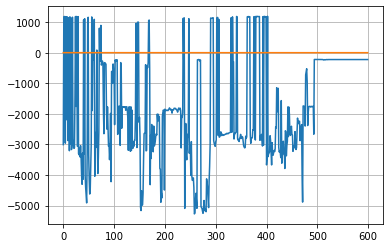

In [237]:
num_games = 200

for i in range(num_games):
    done = False
    state = env.reset()
    score = 0

    while not done:
        action = agent.choose_action(state[np.newaxis,:])
        state_, reward, done, info = env.step(action)
        score +=  reward
        agent.store_transaction(state, action+1, reward, state_, done)
        agent.learn()
        state = state_
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    print(f'epsiode {i}  score {score:.1f}   avg_score {avg_score:.1f}   eps {agent.epsilon:.4f}  mem_cntr {agent.memory.mem_cntr} {info["done_reason"]}')
    eps_hist.append(agent.epsilon)
plt.plot(scores)
plt.plot(eps_hist)
plt.grid(True)
plt.show()

In [239]:
gym = MissileGym.make_simple_scenario((-1500, 500), (-200, 0), missile_vel_abs=1.0)
done = False
reward = 0
obs = gym.reset()
state = gym.get_state()
history = []
alphas_targeting = []
while not done:    
    action_parallel_guidance = agent.choose_action(obs[np.newaxis,:])
    obs, reward, done, info = gym.step(action_parallel_guidance)
    rews.append((action_parallel_guidance, reward))
    state = gym.get_state()
    rews = [(-1,reward),(0,reward),(1,reward),(1,reward)]
    history.append((state, obs, reward, done, info, rews))
    alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alphamax else copysign(gym.missile.alphamax, gym.missile.alpha_targeting))
    
#     if gym.missile.alpha < 0:
#         print(gym.missile.alpha, gym.missile._get_dydt(gym.missile.t, gym.missile.state[:-1])[3])
print(info['done_reason'])

False [-1500   500]
[25.         0.         0.         2.8198421  0.         0.       ]
мы попали


In [225]:
from tqdm import tqdm_notebook

In [233]:
for i in tqdm_notebook(range(10000)):
    agent.learn()

d:\neuro_missile\env_neuro_missile\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [238]:
agent.load_models()

... loading tetris_bot_eval ....
... loading tetris_bot_next ....
